In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Speech_Emotion/RAVDESS.csv')

In [ ]:
print(df.head(5))

                                                Path  ID    Label
0  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   0  neutral
1  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   1     calm
2  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   1     calm
3  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   0  neutral
4  /content/drive/MyDrive/Speech_Emotion/RAVDESS/...   1     calm


In [ ]:
def normalize_coordinates(img):
    image_size=img.shape
    height, width = image_size

    # Create a grid of x and y coordinates
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

    # Normalize the coordinates in the range of -1 to 1
    normalized_x = ((x_coords / (width - 1)) - 0.5) * 2
    normalized_y = ((y_coords / (height - 1)) - 0.5) * 2

    # Stack the normalized x and y coordinates into a single array
    normalized_coords = np.stack([normalized_x, normalized_y], axis=-1)
    img=np.reshape(img,(img.shape[0],img.shape[1],1))
    normalized_coords= np.concatenate([img,normalized_coords],axis=-1)
    width,height,channels=normalized_coords.shape
    normalized_coords=np.reshape(normalized_coords,(channels,width,height))
    return normalized_coords
def create_spectrogram(data, sr):
    # Compute the spectrogram
    X = librosa.stft(y=data, n_fft=1024, hop_length=128, win_length=1024)
    Xdb = librosa.amplitude_to_db(abs(X))

    # Retrieve the corresponding time axis
    t = librosa.frames_to_time(range(Xdb.shape[1]), sr=sr, hop_length=128)

    # Retrieve the corresponding frequency axis
    freqs = librosa.fft_frequencies(sr=sr, n_fft=1024)
    spec=Xdb
    min=np.min(spec)
    max=np.max(spec)
    spec=spec-min
    spec=spec/(max-min)
    spec=spec*255
    spec=np.ceil(spec)
    spec2=cv2.resize(spec,(224,224))
    return normalize_coordinates(spec2)

In [ ]:
uniq=list(pd.unique(df['Label']))
id2label={uniq.index(i):i for i in uniq}
label2id={id2label[ind]:ind for ind in id2label.keys()}

In [ ]:
print(id2label)

{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'disgust', 6: 'fearful', 7: 'surprised'}


In [ ]:
id2label={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'}
label2id={id2label[ind]:ind for ind in id2label.keys()}

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn

In [ ]:
config={
    'label2id':label2id,
    'id2label':id2label,
    'name':'ViT',
    'num_labels':len(id2label.keys())
}

In [ ]:
#Initialisation of the datasets class
#Returns Spectrogram image and the labels
import torch
class datasets(Dataset):
  def __init__(self,paths,ids):
    self.paths=paths
    self.id=ids
  def __len__(self):
    return len(self.paths)
  def __getitem__(self,idx):
    audio,sr=librosa.load(self.paths.iloc[idx],sr=22050)
    return torch.tensor(create_spectrogram(audio,sr)),torch.tensor(self.id.iloc[idx])

In [ ]:
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df,test_size=0.3)
val_df,test_df=train_test_split(val_df,test_size=0.6)

In [ ]:
train_dataset=datasets(train_df['Path'],train_df['ID'])
val_dataset=datasets(val_df['Path'],val_df['ID'])
test_dataset=datasets(test_df['Path'],test_df['ID'])

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=12,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=12,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=12,shuffle=True)

In [ ]:
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00


In [ ]:
#ViT model + Classification head for the model
class model(nn.Module):
  def __init__(self,config,ckpt):
    super().__init__()
    self.config=config
    self.model=timm.create_model(ckpt,pretrained=True)
    for param in self.model.parameters():
      param.requires_grad=True
    self.model_config=self.model.default_cfg
    self.hidden=self.model_config['num_classes']
    self.classifier=nn.Sequential(
        nn.Linear(self.hidden,self.hidden),
        nn.Dropout(0.2),
        nn.Linear(self.hidden,self.config['num_labels'])
    )
  def freeze_parameters(self):
    for param in self.model.parameters():
      param.requires_grad=False
  def forward(self,input,labels=None):
    x=input
    x=self.model(x)
    x=self.classifier(x)
    if(labels is not None):
      loss_fn=nn.CrossEntropyLoss()
      return x,loss_fn(x,labels)
    return x

In [ ]:
ViT=model(config,'vit_large_patch14_clip_224.openai_ft_in12k_in1k')

In [ ]:
#Evaluation metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score
def evaluate(predictions,ground_truth):
  predictions=np.array(predictions.detach().to('cpu'))
  ground_truth=np.array(ground_truth.detach().to('cpu'))
  predictions=np.argmax(predictions,axis=1)
  acc=accuracy_score(predictions,ground_truth)
  prec=precision_score(predictions,ground_truth,average='weighted')
  rec=recall_score(predictions,ground_truth,average='weighted')
  return {
      'accuracy':acc,
      'precision':prec,
      'recall':rec
  }

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#training script for the model
#returns a dictionary with labels loss,accuracy,precision,recall and the values is a list having train loss,val loss respectively
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
def train_model(model,loader,val_loader,optim,epoch):
  loss_curve=[]
  acc_curve=[]
  rec_curve=[]
  prec_curve=[]

  val_loss_curve=[]
  val_acc_curve=[]
  val_rec_curve=[]
  val_prec_curve=[]

  model.train()
  for ep in range(epoch):
    training_loss=0.0
    acc=0
    recall=0
    prec=0
    for st,(input,labels) in tqdm(enumerate(loader)):
      optim.zero_grad()
      input=input.to(torch.float).to(device)
      labels=labels.to(torch.long).to(device)
      logits,loss=model(input,labels)
      training_loss+=loss
      eval=evaluate(logits,labels)
      loss.backward()
      optim.step()
      acc+=eval['accuracy']
      recall+=eval['recall']
      prec+=eval['precision']
      if((st+1)%14==0):
        loss_curve.append(training_loss.detach().cpu()/(st+1))
        acc_curve.append(acc/(st+1))
        rec_curve.append(recall/(st+1))
        prec_curve.append(prec/(st+1))
    model.eval()
    with torch.no_grad():
      val_loss=0.0
      acc=0
      recall=0
      prec=0
      for st,(input,labels) in tqdm(enumerate(val_loader)):
        input=input.to(torch.float).to(device)
        labels=labels.to(torch.long).to(device)
        logits,loss=model(input,labels)
        val_loss+=loss
        eval=evaluate(logits,labels)
        acc+=eval['accuracy']
        recall+=eval['recall']
        prec+=eval['precision']
        if((st+1)%14==0):
          val_loss_curve.append(val_loss.detach().cpu()/(st+1))
          val_acc_curve.append(acc/(st+1))
          val_rec_curve.append(recall/(st+1))
          val_prec_curve.append(prec/(st+1))

  return {'Loss':[loss_curve,val_loss_curve],
          'Accuracy':[acc_curve,val_acc_curve],
          'Precision':[prec_curve,val_prec_curve],
          'Recall':[rec_curve,val_rec_curve]}

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torch.optim import Adam
ViT.freeze_parameters()
crit=Adam(ViT.parameters(),lr=0.001)
losses=train_model(ViT.to(device),train_loader,val_loader,crit,10)

84it [00:44,  1.89it/s]
15it [00:06,  2.30it/s]
84it [00:41,  2.04it/s]
15it [00:07,  1.95it/s]
84it [00:41,  2.03it/s]
15it [00:07,  2.10it/s]
84it [00:41,  2.01it/s]
15it [00:06,  2.31it/s]
84it [00:42,  1.98it/s]
15it [00:07,  2.02it/s]
84it [00:41,  2.00it/s]
15it [00:06,  2.28it/s]
84it [00:40,  2.05it/s]
15it [00:07,  2.12it/s]
84it [00:40,  2.08it/s]
15it [00:07,  2.01it/s]
84it [00:41,  2.04it/s]
15it [00:06,  2.23it/s]
84it [00:41,  2.04it/s]
15it [00:06,  2.34it/s]


Total Epochs -43

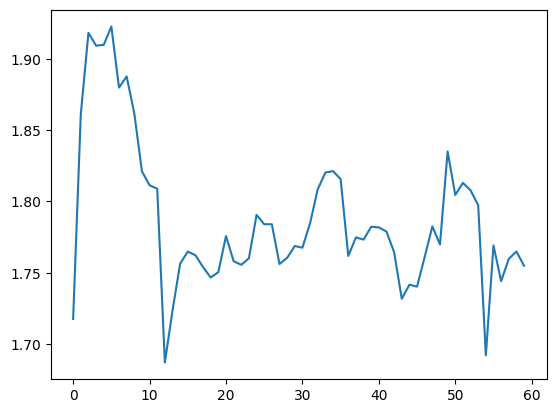

In [ ]:
plt.plot([i for i in range(len(losses['Loss'][0]))],losses['Loss'][0])
#Training Loss plot

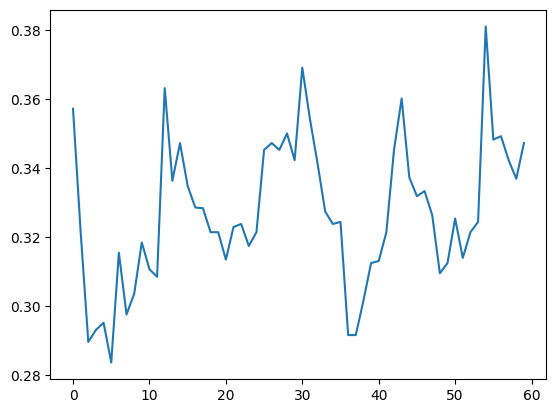

In [ ]:
plt.plot([i for i in range(len(losses['Accuracy'][0]))],losses['Accuracy'][0])
#Training Accuracy Plot

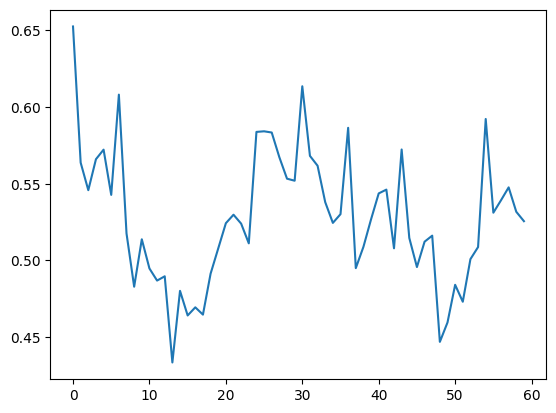

In [ ]:
plt.plot([i for i in range(len(losses['Precision'][0]))],losses['Precision'][0])
#Training Precision Plot

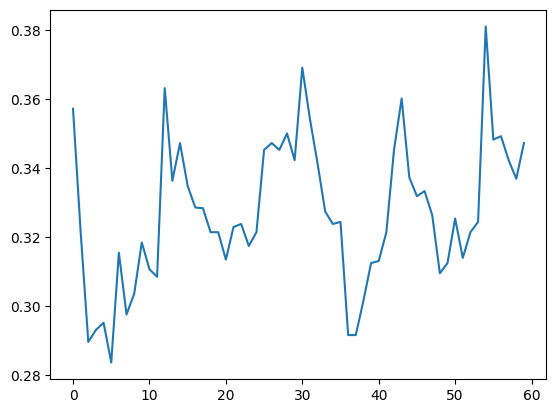

In [ ]:
plt.plot([i for i in range(len(losses['Recall'][0]))],losses['Recall'][0])
#Training Recall plot

In [ ]:
#Evaluation funciton for testing data
#returns predictions and the ground truth for each input
def eval(model,test_loader):
  with torch.no_grad():
      predictions=None
      ground_truth=None
      for st,(input,labels) in tqdm(enumerate(test_loader)):
        input=input.to(torch.float).to(device)
        labels=labels.to(torch.long).to(device)
        logits,loss=model(input,labels)
        pred=np.array(logits.detach().cpu())
        pred=np.argmax(pred,axis=1)
        labs=np.array(labels.detach().cpu())
        pred=np.reshape(pred,(1,pred.shape[0]))
        labs=np.reshape(labs,(1,labs.shape[0]))
        if(predictions is None):
          predictions=pred
          ground_truth=labs
        else:
          predictions=np.concatenate([predictions,pred],axis=1)
          ground_truth=np.concatenate([ground_truth,labs],axis=1)
      return predictions,ground_truth

In [ ]:
predictions,ground_truth=eval(ViT,test_loader)

22it [00:10,  2.07it/s]


In [ ]:
labels=[key for key in label2id.keys()]

In [ ]:
ground_truth=np.reshape(ground_truth,(ground_truth.shape[-1]))
predictions=np.reshape(predictions,(predictions.shape[-1]))

In [ ]:
predictins=[id2label[i] for i in predictions]
ground_truth=[id2label[i] for i in ground_truth]

In [ ]:
print(predictins)
print(ground_truth)

['angry', 'disgust', 'angry', 'surprised', 'calm', 'happy', 'angry', 'surprised', 'angry', 'angry', 'happy', 'angry', 'surprised', 'angry', 'surprised', 'angry', 'surprised', 'surprised', 'angry', 'fearful', 'angry', 'angry', 'surprised', 'angry', 'disgust', 'angry', 'angry', 'happy', 'surprised', 'calm', 'surprised', 'angry', 'angry', 'angry', 'angry', 'angry', 'happy', 'calm', 'angry', 'angry', 'angry', 'angry', 'surprised', 'angry', 'surprised', 'angry', 'surprised', 'surprised', 'angry', 'calm', 'disgust', 'angry', 'happy', 'disgust', 'angry', 'angry', 'sad', 'surprised', 'angry', 'angry', 'angry', 'angry', 'surprised', 'angry', 'angry', 'angry', 'disgust', 'surprised', 'angry', 'surprised', 'angry', 'angry', 'surprised', 'angry', 'disgust', 'surprised', 'angry', 'surprised', 'disgust', 'surprised', 'angry', 'angry', 'fearful', 'calm', 'happy', 'angry', 'surprised', 'surprised', 'angry', 'angry', 'angry', 'calm', 'angry', 'calm', 'angry', 'angry', 'angry', 'surprised', 'fearful', '

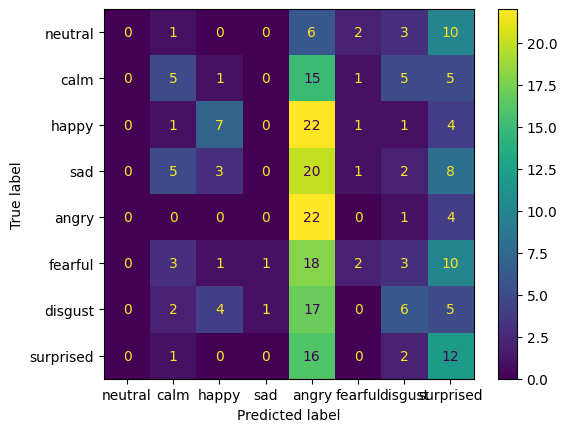

In [ ]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(ground_truth,predictins,labels=labels)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=labels)
disp.plot()

22050


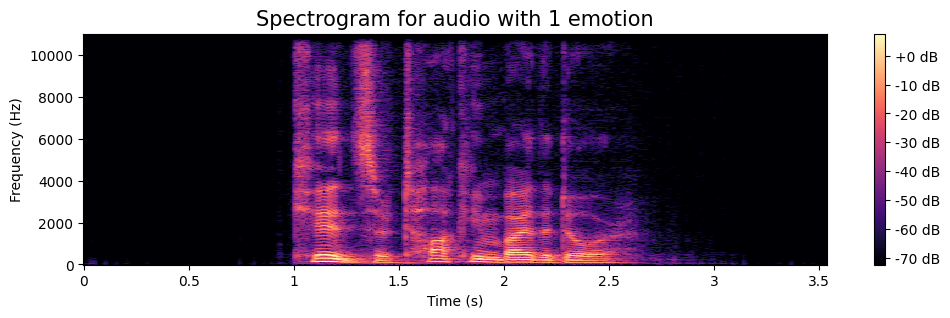

In [ ]:
data=df['Path'].iloc[1]
audio,sr=librosa.load(data,sr=22050)
print(sr)
spec=create_spectrogram(audio,sr,df['ID'].iloc[1])
#Sample image